Epoch    0 | Loss: 1.026e+00
Epoch  200 | Loss: 1.161e-03
Epoch  400 | Loss: 1.658e-05
Epoch  600 | Loss: 1.247e-05
Epoch  800 | Loss: 1.241e-05
Epoch 1000 | Loss: 1.233e-05
Epoch 1200 | Loss: 1.224e-05
Epoch 1400 | Loss: 1.214e-05
Epoch 1600 | Loss: 1.202e-05
Epoch 1800 | Loss: 1.189e-05


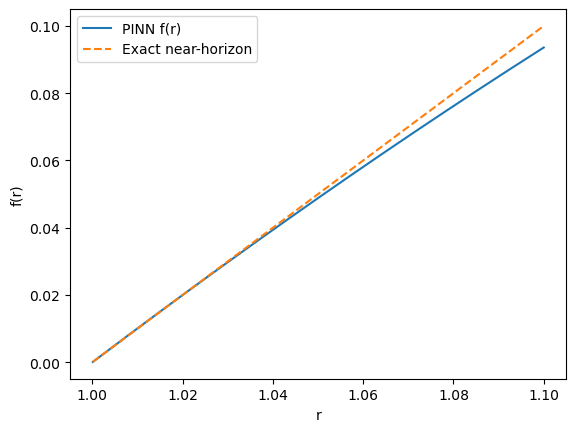

In [1]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import matplotlib.pyplot as plt

class MetricPINN(nn.Module):
    def __init__(self, hidden=32, layers=3):
        super().__init__()

        net = [nn.Linear(1, hidden), nn.Tanh()]
        for _ in range(layers - 1):
            net += [nn.Linear(hidden, hidden), nn.Tanh()]
        net.append(nn.Linear(hidden, 1))  # f_tilde(r)

        self.net = nn.Sequential(*net)

    def forward(self, r):
        return self.net(r)

def grad(u, x):
    g = autograd.grad(
        u,
        x,
        grad_outputs=torch.ones_like(u),
        create_graph=True,
        allow_unused=True
    )[0]
    return torch.zeros_like(x) if g is None else g

def s_grad(u, x):
    return grad(grad(u, x), x)

def einstein_res(f, g, r):
    eps = 1e-6
    f_safe = f + eps
    g_safe = g + eps

    f_r = grad(f, r)
    f_rr = s_grad(f, r)
    g_r = grad(g, r)

    R_tt = (
        f_rr / (2 * g_safe)
        - f_r / (4 * g_safe) * (f_r / f_safe + g_r / g_safe)
        + f_r / (r * g_safe)
    )

    return R_tt

# Near-horizon
r_h = 1.0
eps = 0.1
delta = 1e-4
N = 200

r = torch.linspace(
    r_h + delta,
    r_h + eps,
    N,
    requires_grad=True
).view(-1, 1)

model = MetricPINN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# norm point
r0 = torch.tensor([[1.01]], requires_grad=True)

for epoch in range(2000):
    optimizer.zero_grad()

    f_tilde = model(r)
    f = (r - 1.0) * f_tilde
    g = 1.0 / (f + 1e-6)

    # Einstein PDE loss
    R_tt = einstein_res(f, g, r)
    scale = torch.abs(R_tt.detach()).mean() + 1.0
    loss_pde = ((R_tt / scale) ** 2).mean()

    # gauge
    f0 = (r0 - 1.0) * model(r0)
    df_dr_0 = grad(f0, r0)
    loss_norm = (df_dr_0 - 1.0) ** 2

    loss = loss_pde + loss_norm
    loss.backward()
    optimizer.step()

    if epoch % 200 == 0:
        print(f"Epoch {epoch:4d} | Loss: {loss.item():.3e}")

with torch.no_grad():
    f = (r - 1.0) * model(r)

plt.plot(
    r.detach().cpu().numpy(),
    f.detach().cpu().numpy(),
    label="PINN f(r)"
)
plt.plot(
    r.detach().cpu().numpy(),
    (r - 1.0).detach().cpu().numpy(),
    "--",
    label="Exact near-horizon"
)

plt.xlabel("r")
plt.ylabel("f(r)")
plt.legend()
plt.show()

Ablation test 1: No horizon normalization

Epoch    0 | Loss: 1.439e-10
Epoch  200 | Loss: 2.073e-13
Epoch  400 | Loss: 1.665e-13
Epoch  600 | Loss: 1.365e-13
Epoch  800 | Loss: 1.138e-13
Epoch 1000 | Loss: 9.628e-14
Epoch 1200 | Loss: 8.249e-14
Epoch 1400 | Loss: 7.147e-14
Epoch 1600 | Loss: 6.250e-14
Epoch 1800 | Loss: 5.512e-14


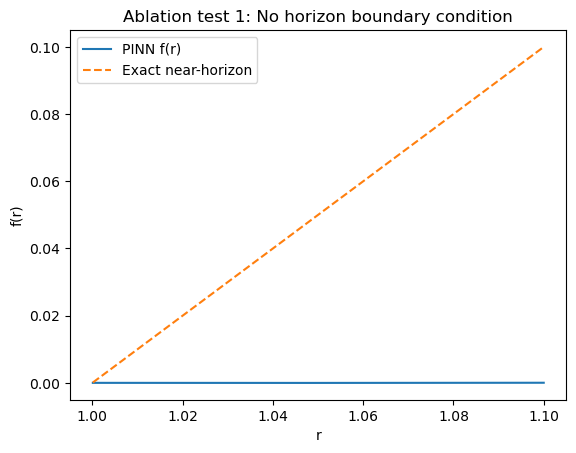

In [8]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import matplotlib.pyplot as plt

class MetricPINN(nn.Module):
    def __init__(self, hidden=32, layers=3):
        super().__init__()

        net = [nn.Linear(1, hidden), nn.Tanh()]
        for _ in range(layers - 1):
            net += [nn.Linear(hidden, hidden), nn.Tanh()]
        net.append(nn.Linear(hidden, 1))  # f_tilde(r)

        self.net = nn.Sequential(*net)

    def forward(self, r):
        return self.net(r)

def grad(u, x):
    g = autograd.grad(
        u,
        x,
        grad_outputs=torch.ones_like(u),
        create_graph=True,
        allow_unused=True
    )[0]
    return torch.zeros_like(x) if g is None else g

def s_grad(u, x):
    return grad(grad(u, x), x)

def einstein_res(f, g, r):
    eps = 1e-6
    f_safe = f + eps
    g_safe = g + eps

    f_r = grad(f, r)
    f_rr = s_grad(f, r)
    g_r = grad(g, r)

    R_tt = (
        f_rr / (2 * g_safe)
        - f_r / (4 * g_safe) * (f_r / f_safe + g_r / g_safe)
        + f_r / (r * g_safe)
    )

    return R_tt

# Near-horizon
r_h = 1.0
eps = 0.1
delta = 1e-4
N = 200

r = torch.linspace(
    r_h + delta,
    r_h + eps,
    N,
    requires_grad=True
).view(-1, 1)

model = MetricPINN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# norm point
r0 = torch.tensor([[1.01]], requires_grad=True)

for epoch in range(2000):
    optimizer.zero_grad()

    f_tilde = model(r)
    f = (r - 1.0) * f_tilde
    g = 1.0 / (f + 1e-6)

    # Einstein PDE loss
    R_tt = einstein_res(f, g, r)
    scale = torch.abs(R_tt.detach()).mean() + 1.0
    loss_pde = ((R_tt / scale) ** 2).mean()

    # gauge
    f0 = (r0 - 1.0) * model(r0)
    df_dr_0 = grad(f0, r0)

    loss = loss_pde
    loss.backward()
    optimizer.step()

    if epoch % 200 == 0:
        print(f"Epoch {epoch:4d} | Loss: {loss.item():.3e}")

with torch.no_grad():
    f = (r - 1.0) * model(r)

plt.plot(
    r.detach().cpu().numpy(),
    f.detach().cpu().numpy(),
    label="PINN f(r)"
)
plt.plot(
    r.detach().cpu().numpy(),
    (r - 1.0).detach().cpu().numpy(),
    "--",
    label="Exact near-horizon"
)

plt.xlabel("r")
plt.ylabel("f(r)")
plt.legend()
plt.title("Ablation test 1: No horizon boundary condition")
plt.show()

Ablation test 2: No residual normalization

Epoch    0 | Loss: 1.177e+00
Epoch  200 | Loss: 2.771e-03
Epoch  400 | Loss: 2.137e-03
Epoch  600 | Loss: 1.020e-03
Epoch  800 | Loss: 8.911e-05
Epoch 1000 | Loss: 7.558e-06
Epoch 1200 | Loss: 7.105e-06
Epoch 1400 | Loss: 7.011e-06
Epoch 1600 | Loss: 6.904e-06
Epoch 1800 | Loss: 6.785e-06


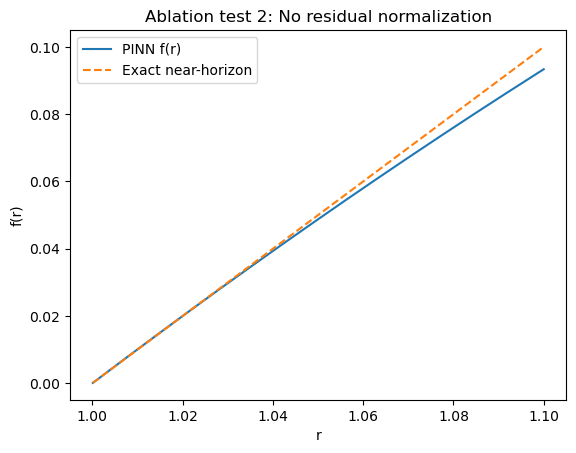

In [9]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import matplotlib.pyplot as plt

class MetricPINN(nn.Module):
    def __init__(self, hidden=32, layers=3):
        super().__init__()

        net = [nn.Linear(1, hidden), nn.Tanh()]
        for _ in range(layers - 1):
            net += [nn.Linear(hidden, hidden), nn.Tanh()]
        net.append(nn.Linear(hidden, 1))  # f_tilde(r)

        self.net = nn.Sequential(*net)

    def forward(self, r):
        return self.net(r)

def grad(u, x):
    g = autograd.grad(
        u,
        x,
        grad_outputs=torch.ones_like(u),
        create_graph=True,
        allow_unused=True
    )[0]
    return torch.zeros_like(x) if g is None else g

def s_grad(u, x):
    return grad(grad(u, x), x)

def einstein_res(f, g, r):
    eps = 1e-6
    f_safe = f + eps
    g_safe = g + eps

    f_r = grad(f, r)
    f_rr = s_grad(f, r)
    g_r = grad(g, r)

    R_tt = (
        f_rr / (2 * g_safe)
        - f_r / (4 * g_safe) * (f_r / f_safe + g_r / g_safe)
        + f_r / (r * g_safe)
    )

    return R_tt

# Near-horizon
r_h = 1.0
eps = 0.1
delta = 1e-4
N = 200

r = torch.linspace(
    r_h + delta,
    r_h + eps,
    N,
    requires_grad=True
).view(-1, 1)

model = MetricPINN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# norm point
r0 = torch.tensor([[1.01]], requires_grad=True)

for epoch in range(2000):
    optimizer.zero_grad()

    f_tilde = model(r)
    f = (r - 1.0) * f_tilde
    g = 1.0 / (f + 1e-6)

    # Einstein PDE loss
    R_tt = einstein_res(f, g, r)
   
    loss_pde = (R_tt** 2).mean()

    # gauge
    f0 = (r0 - 1.0) * model(r0)
    df_dr_0 = grad(f0, r0)
    loss_norm = (df_dr_0 - 1.0) ** 2

    loss = loss_pde + loss_norm
    loss.backward()
    optimizer.step()

    if epoch % 200 == 0:
        print(f"Epoch {epoch:4d} | Loss: {loss.item():.3e}")

with torch.no_grad():
    f = (r - 1.0) * model(r)

plt.plot(
    r.detach().cpu().numpy(),
    f.detach().cpu().numpy(),
    label="PINN f(r)"
)
plt.plot(
    r.detach().cpu().numpy(),
    (r - 1.0).detach().cpu().numpy(),
    "--",
    label="Exact near-horizon"
)

plt.xlabel("r")
plt.ylabel("f(r)")
plt.legend()
plt.title("Ablation test 2: No residual normalization")
plt.show()

Ablation test 3: Wider domain (eps=0.2)

Epoch    0 | Loss: 6.820e-01
Epoch  200 | Loss: 9.478e-05
Epoch  400 | Loss: 4.285e-05
Epoch  600 | Loss: 3.651e-05
Epoch  800 | Loss: 2.917e-05
Epoch 1000 | Loss: 2.169e-05
Epoch 1200 | Loss: 1.491e-05
Epoch 1400 | Loss: 9.408e-06
Epoch 1600 | Loss: 5.426e-06
Epoch 1800 | Loss: 2.892e-06


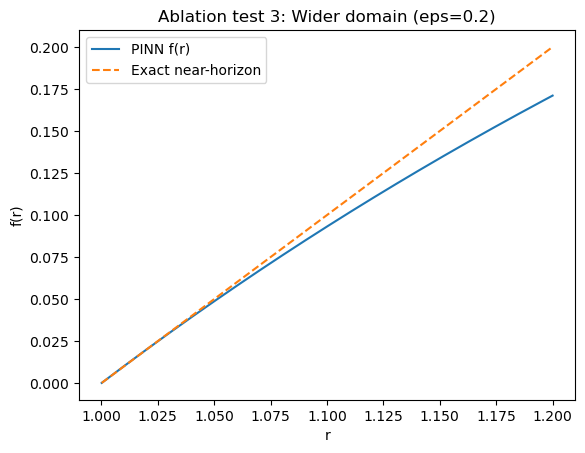

In [10]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import matplotlib.pyplot as plt

class MetricPINN(nn.Module):
    def __init__(self, hidden=32, layers=3):
        super().__init__()

        net = [nn.Linear(1, hidden), nn.Tanh()]
        for _ in range(layers - 1):
            net += [nn.Linear(hidden, hidden), nn.Tanh()]
        net.append(nn.Linear(hidden, 1))  # f_tilde(r)

        self.net = nn.Sequential(*net)

    def forward(self, r):
        return self.net(r)

def grad(u, x):
    g = autograd.grad(
        u,
        x,
        grad_outputs=torch.ones_like(u),
        create_graph=True,
        allow_unused=True
    )[0]
    return torch.zeros_like(x) if g is None else g

def s_grad(u, x):
    return grad(grad(u, x), x)

def einstein_res(f, g, r):
    eps = 1e-6
    f_safe = f + eps
    g_safe = g + eps

    f_r = grad(f, r)
    f_rr = s_grad(f, r)
    g_r = grad(g, r)

    R_tt = (
        f_rr / (2 * g_safe)
        - f_r / (4 * g_safe) * (f_r / f_safe + g_r / g_safe)
        + f_r / (r * g_safe)
    )

    return R_tt

# Near-horizon
r_h = 1.0
eps = 0.2
delta = 1e-4
N = 200

r = torch.linspace(
    r_h + delta,
    r_h + eps,
    N,
    requires_grad=True
).view(-1, 1)

model = MetricPINN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# norm point
r0 = torch.tensor([[1.01]], requires_grad=True)

for epoch in range(2000):
    optimizer.zero_grad()

    f_tilde = model(r)
    f = (r - 1.0) * f_tilde
    g = 1.0 / (f + 1e-6)

    # Einstein PDE loss
    R_tt = einstein_res(f, g, r)
    scale = torch.abs(R_tt.detach()).mean() + 1.0
    loss_pde = ((R_tt / scale) ** 2).mean()

    # gauge
    f0 = (r0 - 1.0) * model(r0)
    df_dr_0 = grad(f0, r0)
    loss_norm = (df_dr_0 - 1.0) ** 2

    loss = loss_pde + loss_norm
    loss.backward()
    optimizer.step()

    if epoch % 200 == 0:
        print(f"Epoch {epoch:4d} | Loss: {loss.item():.3e}")

with torch.no_grad():
    f = (r - 1.0) * model(r)

plt.plot(
    r.detach().cpu().numpy(),
    f.detach().cpu().numpy(),
    label="PINN f(r)"
)
plt.plot(
    r.detach().cpu().numpy(),
    (r - 1.0).detach().cpu().numpy(),
    "--",
    label="Exact near-horizon"
)

plt.xlabel("r")
plt.ylabel("f(r)")
plt.legend()
plt.title("Ablation test 3: Wider domain (eps=0.2)")
plt.show()

Ablation test 3: Wider domain (eps=0.3)

Epoch    0 | Loss: 9.413e-01
Epoch  200 | Loss: 1.989e-04
Epoch  400 | Loss: 1.691e-04
Epoch  600 | Loss: 1.342e-04
Epoch  800 | Loss: 9.689e-05
Epoch 1000 | Loss: 6.210e-05
Epoch 1200 | Loss: 3.371e-05
Epoch 1400 | Loss: 1.484e-05
Epoch 1600 | Loss: 5.393e-06
Epoch 1800 | Loss: 1.957e-06


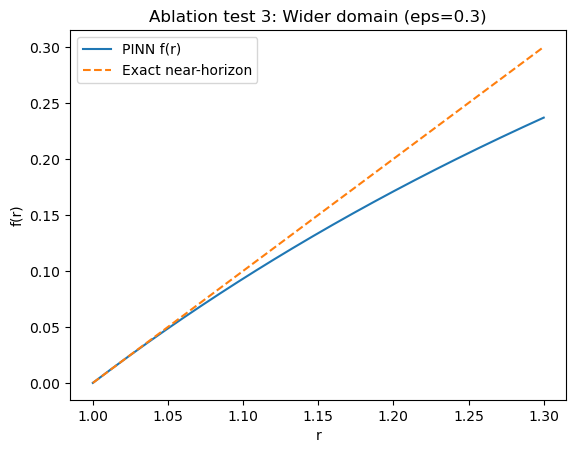

In [11]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import matplotlib.pyplot as plt

class MetricPINN(nn.Module):
    def __init__(self, hidden=32, layers=3):
        super().__init__()

        net = [nn.Linear(1, hidden), nn.Tanh()]
        for _ in range(layers - 1):
            net += [nn.Linear(hidden, hidden), nn.Tanh()]
        net.append(nn.Linear(hidden, 1))  # f_tilde(r)

        self.net = nn.Sequential(*net)

    def forward(self, r):
        return self.net(r)

def grad(u, x):
    g = autograd.grad(
        u,
        x,
        grad_outputs=torch.ones_like(u),
        create_graph=True,
        allow_unused=True
    )[0]
    return torch.zeros_like(x) if g is None else g

def s_grad(u, x):
    return grad(grad(u, x), x)

def einstein_res(f, g, r):
    eps = 1e-6
    f_safe = f + eps
    g_safe = g + eps

    f_r = grad(f, r)
    f_rr = s_grad(f, r)
    g_r = grad(g, r)

    R_tt = (
        f_rr / (2 * g_safe)
        - f_r / (4 * g_safe) * (f_r / f_safe + g_r / g_safe)
        + f_r / (r * g_safe)
    )

    return R_tt

# Near-horizon
r_h = 1.0
eps = 0.3
delta = 1e-4
N = 200

r = torch.linspace(
    r_h + delta,
    r_h + eps,
    N,
    requires_grad=True
).view(-1, 1)

model = MetricPINN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# norm point
r0 = torch.tensor([[1.01]], requires_grad=True)

for epoch in range(2000):
    optimizer.zero_grad()

    f_tilde = model(r)
    f = (r - 1.0) * f_tilde
    g = 1.0 / (f + 1e-6)

    # Einstein PDE loss
    R_tt = einstein_res(f, g, r)
    scale = torch.abs(R_tt.detach()).mean() + 1.0
    loss_pde = ((R_tt / scale) ** 2).mean()

    # gauge
    f0 = (r0 - 1.0) * model(r0)
    df_dr_0 = grad(f0, r0)
    loss_norm = (df_dr_0 - 1.0) ** 2

    loss = loss_pde + loss_norm
    loss.backward()
    optimizer.step()

    if epoch % 200 == 0:
        print(f"Epoch {epoch:4d} | Loss: {loss.item():.3e}")

with torch.no_grad():
    f = (r - 1.0) * model(r)

plt.plot(
    r.detach().cpu().numpy(),
    f.detach().cpu().numpy(),
    label="PINN f(r)"
)
plt.plot(
    r.detach().cpu().numpy(),
    (r - 1.0).detach().cpu().numpy(),
    "--",
    label="Exact near-horizon"
)

plt.xlabel("r")
plt.ylabel("f(r)")
plt.legend()
plt.title("Ablation test 3: Wider domain (eps=0.3)")
plt.show()

Ablation test 3: Wider domain (eps=0.4)

Epoch    0 | Loss: 5.674e-01
Epoch  200 | Loss: 4.143e-04
Epoch  400 | Loss: 3.608e-04
Epoch  600 | Loss: 2.900e-04
Epoch  800 | Loss: 2.063e-04
Epoch 1000 | Loss: 1.223e-04
Epoch 1200 | Loss: 5.759e-05
Epoch 1400 | Loss: 2.206e-05
Epoch 1600 | Loss: 8.640e-06
Epoch 1800 | Loss: 5.077e-06


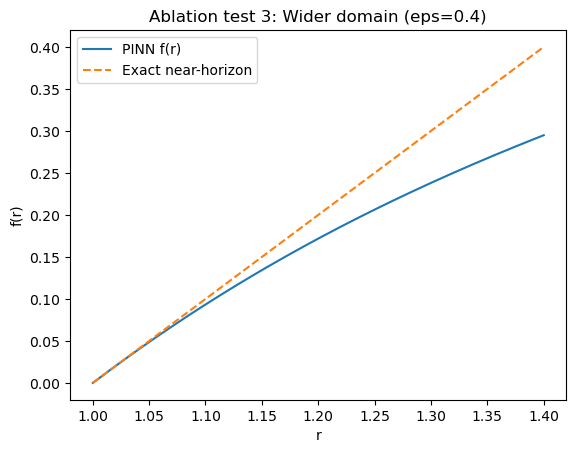

In [12]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import matplotlib.pyplot as plt

class MetricPINN(nn.Module):
    def __init__(self, hidden=32, layers=3):
        super().__init__()

        net = [nn.Linear(1, hidden), nn.Tanh()]
        for _ in range(layers - 1):
            net += [nn.Linear(hidden, hidden), nn.Tanh()]
        net.append(nn.Linear(hidden, 1))  # f_tilde(r)

        self.net = nn.Sequential(*net)

    def forward(self, r):
        return self.net(r)

def grad(u, x):
    g = autograd.grad(
        u,
        x,
        grad_outputs=torch.ones_like(u),
        create_graph=True,
        allow_unused=True
    )[0]
    return torch.zeros_like(x) if g is None else g

def s_grad(u, x):
    return grad(grad(u, x), x)

def einstein_res(f, g, r):
    eps = 1e-6
    f_safe = f + eps
    g_safe = g + eps

    f_r = grad(f, r)
    f_rr = s_grad(f, r)
    g_r = grad(g, r)

    R_tt = (
        f_rr / (2 * g_safe)
        - f_r / (4 * g_safe) * (f_r / f_safe + g_r / g_safe)
        + f_r / (r * g_safe)
    )

    return R_tt

# Near-horizon
r_h = 1.0
eps = 0.4
delta = 1e-4
N = 200

r = torch.linspace(
    r_h + delta,
    r_h + eps,
    N,
    requires_grad=True
).view(-1, 1)

model = MetricPINN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# norm point
r0 = torch.tensor([[1.01]], requires_grad=True)

for epoch in range(2000):
    optimizer.zero_grad()

    f_tilde = model(r)
    f = (r - 1.0) * f_tilde
    g = 1.0 / (f + 1e-6)

    # Einstein PDE loss
    R_tt = einstein_res(f, g, r)
    scale = torch.abs(R_tt.detach()).mean() + 1.0
    loss_pde = ((R_tt / scale) ** 2).mean()

    # gauge
    f0 = (r0 - 1.0) * model(r0)
    df_dr_0 = grad(f0, r0)
    loss_norm = (df_dr_0 - 1.0) ** 2

    loss = loss_pde + loss_norm
    loss.backward()
    optimizer.step()

    if epoch % 200 == 0:
        print(f"Epoch {epoch:4d} | Loss: {loss.item():.3e}")

with torch.no_grad():
    f = (r - 1.0) * model(r)

plt.plot(
    r.detach().cpu().numpy(),
    f.detach().cpu().numpy(),
    label="PINN f(r)"
)
plt.plot(
    r.detach().cpu().numpy(),
    (r - 1.0).detach().cpu().numpy(),
    "--",
    label="Exact near-horizon"
)

plt.xlabel("r")
plt.ylabel("f(r)")
plt.legend()
plt.title("Ablation test 3: Wider domain (eps=0.4)")
plt.show()

Ablation test 3: Wider domain (eps=0.5)

Epoch    0 | Loss: 7.088e-01
Epoch  200 | Loss: 6.036e-04
Epoch  400 | Loss: 4.230e-04
Epoch  600 | Loss: 1.958e-04
Epoch  800 | Loss: 4.529e-05
Epoch 1000 | Loss: 1.402e-05
Epoch 1200 | Loss: 1.050e-05
Epoch 1400 | Loss: 8.528e-06
Epoch 1600 | Loss: 6.759e-06
Epoch 1800 | Loss: 5.218e-06


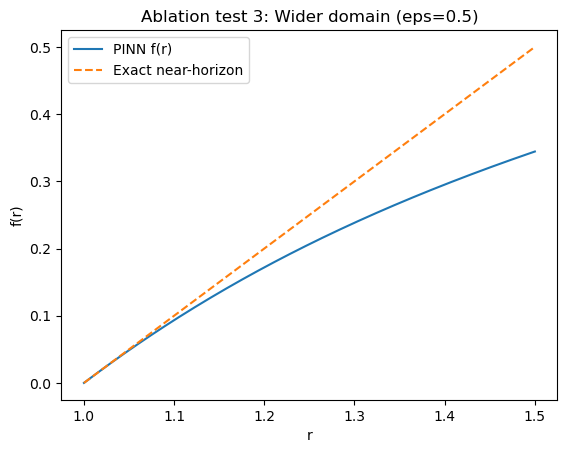

In [13]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import matplotlib.pyplot as plt

class MetricPINN(nn.Module):
    def __init__(self, hidden=32, layers=3):
        super().__init__()

        net = [nn.Linear(1, hidden), nn.Tanh()]
        for _ in range(layers - 1):
            net += [nn.Linear(hidden, hidden), nn.Tanh()]
        net.append(nn.Linear(hidden, 1))  # f_tilde(r)

        self.net = nn.Sequential(*net)

    def forward(self, r):
        return self.net(r)

def grad(u, x):
    g = autograd.grad(
        u,
        x,
        grad_outputs=torch.ones_like(u),
        create_graph=True,
        allow_unused=True
    )[0]
    return torch.zeros_like(x) if g is None else g

def s_grad(u, x):
    return grad(grad(u, x), x)

def einstein_res(f, g, r):
    eps = 1e-6
    f_safe = f + eps
    g_safe = g + eps

    f_r = grad(f, r)
    f_rr = s_grad(f, r)
    g_r = grad(g, r)

    R_tt = (
        f_rr / (2 * g_safe)
        - f_r / (4 * g_safe) * (f_r / f_safe + g_r / g_safe)
        + f_r / (r * g_safe)
    )

    return R_tt

# Near-horizon
r_h = 1.0
eps = 0.5
delta = 1e-4
N = 200

r = torch.linspace(
    r_h + delta,
    r_h + eps,
    N,
    requires_grad=True
).view(-1, 1)

model = MetricPINN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# norm point
r0 = torch.tensor([[1.01]], requires_grad=True)

for epoch in range(2000):
    optimizer.zero_grad()

    f_tilde = model(r)
    f = (r - 1.0) * f_tilde
    g = 1.0 / (f + 1e-6)

    # Einstein PDE loss
    R_tt = einstein_res(f, g, r)
    scale = torch.abs(R_tt.detach()).mean() + 1.0
    loss_pde = ((R_tt / scale) ** 2).mean()

    # gauge
    f0 = (r0 - 1.0) * model(r0)
    df_dr_0 = grad(f0, r0)
    loss_norm = (df_dr_0 - 1.0) ** 2

    loss = loss_pde + loss_norm
    loss.backward()
    optimizer.step()

    if epoch % 200 == 0:
        print(f"Epoch {epoch:4d} | Loss: {loss.item():.3e}")

with torch.no_grad():
    f = (r - 1.0) * model(r)

plt.plot(
    r.detach().cpu().numpy(),
    f.detach().cpu().numpy(),
    label="PINN f(r)"
)
plt.plot(
    r.detach().cpu().numpy(),
    (r - 1.0).detach().cpu().numpy(),
    "--",
    label="Exact near-horizon"
)

plt.xlabel("r")
plt.ylabel("f(r)")
plt.legend()
plt.title("Ablation test 3: Wider domain (eps=0.5)")
plt.show()

Ablation test 4: No horizon factor

"In the near-horizon, single-equation, gauge-fixed setting, the Einstein equation itself enforces the correct leading behavior."

Epoch    0 | Loss: 1.721e+00
Epoch  200 | Loss: 2.219e-05
Epoch  400 | Loss: 2.174e-05
Epoch  600 | Loss: 2.119e-05
Epoch  800 | Loss: 2.052e-05
Epoch 1000 | Loss: 1.977e-05
Epoch 1200 | Loss: 1.892e-05
Epoch 1400 | Loss: 1.801e-05
Epoch 1600 | Loss: 1.704e-05
Epoch 1800 | Loss: 1.601e-05


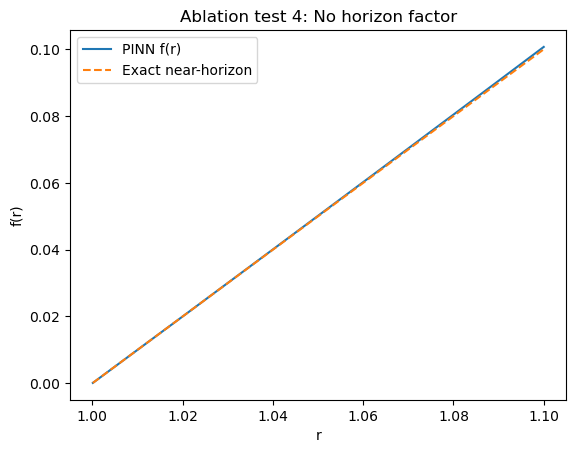

In [18]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import matplotlib.pyplot as plt

class MetricPINN(nn.Module):
    def __init__(self, hidden=32, layers=3):
        super().__init__()

        net = [nn.Linear(1, hidden), nn.Tanh()]
        for _ in range(layers - 1):
            net += [nn.Linear(hidden, hidden), nn.Tanh()]
        net.append(nn.Linear(hidden, 1))  # f_tilde(r)

        self.net = nn.Sequential(*net)

    def forward(self, r):
        return self.net(r)

def grad(u, x):
    g = autograd.grad(
        u,
        x,
        grad_outputs=torch.ones_like(u),
        create_graph=True,
        allow_unused=True
    )[0]
    return torch.zeros_like(x) if g is None else g

def s_grad(u, x):
    return grad(grad(u, x), x)

def einstein_res(f, g, r):
    eps = 1e-6
    f_safe = f + eps
    g_safe = g + eps

    f_r = grad(f, r)
    f_rr = s_grad(f, r)
    g_r = grad(g, r)

    R_tt = (
        f_rr / (2 * g_safe)
        - f_r / (4 * g_safe) * (f_r / f_safe + g_r / g_safe)
        + f_r / (r * g_safe)
    )

    return R_tt

# Near-horizon
r_h = 1.0
eps = 0.1
delta = 1e-4
N = 200

r = torch.linspace(
    r_h + delta,
    r_h + eps,
    N,
    requires_grad=True
).view(-1, 1)

model = MetricPINN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# norm point
r0 = torch.tensor([[1.01]], requires_grad=True)

for epoch in range(2000):
    optimizer.zero_grad()

    f = model(r)
    g = 1.0 / (f + 1e-6)

    # Einstein PDE loss
    R_tt = einstein_res(f, g, r)
    scale = torch.abs(R_tt.detach()).mean() + 1.0
    loss_pde = ((R_tt / scale) ** 2).mean()

    # gauge
    f0 = (r0 - 1.0) * model(r0)
    df_dr_0 = grad(f0, r0)
    loss_norm = (df_dr_0 - 1.0) ** 2

    loss = loss_pde + loss_norm
    loss.backward()
    optimizer.step()

    if epoch % 200 == 0:
        print(f"Epoch {epoch:4d} | Loss: {loss.item():.3e}")

with torch.no_grad():
    f = (r - 1.0) * model(r)

plt.plot(
    r.detach().cpu().numpy(),
    f.detach().cpu().numpy(),
    label="PINN f(r)"
)
plt.plot(
    r.detach().cpu().numpy(),
    (r - 1.0).detach().cpu().numpy(),
    "--",
    label="Exact near-horizon"
)

plt.xlabel("r")
plt.ylabel("f(r)")
plt.legend()
plt.title("Ablation test 4: No horizon factor")
plt.show()